In [1]:
from memflow.phasespace.phasespace import PhaseSpace
import tensorflow as tf
from memflow.hardscatter import hardscatter
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

/home/valsdav/code/MEM/MEMFlow/myenv/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-04 12:19:48.094469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 12:19:48.995485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-04 12:19:48.995589: W tensorflow/compiler/xla/stream_execut

In [2]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()

2023-01-04 11:12:52.088282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-04 11:12:52.088334: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
[INFO] (pdfflow.pflow) Loading member 0 from NNPDF40_nnlo_hessian_pdfas
[INFO] (pdfflow.pflow) Building tf.Graph, this can take a while...


## Phase space points generation

In [2]:
E_CM = 13000
N = 10000
phasespace = PhaseSpace(E_CM, [21,21], [25,6,-6])

2023-01-04 12:19:50.203716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-04 12:19:50.203761: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
%%timeit
p, momenta, w , x1, x2 = phasespace.generate_random_phase_space_points(N, )

50.9 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
print(f"Time for 1ev with 1e6 buffer: {319 / N} ms")

Time for 1ev with 1e6 buffer: 0.0319 ms


In [5]:
p, momenta, w , x1, x2 = phasespace.generate_random_phase_space_points(N)

In [6]:
p2 = phasespace.get_ps_from_momenta(momenta, x1, x2)

# p.d.f evaluation

In [15]:
q2 = tf.cast(tf.ones_like(x1)*91.88**2, dtype=tf.float64)

pdf_weight = torch.tensor(
        (pdf.xfxQ2(
            [21],
            tf.convert_to_tensor(x1, dtype=tf.float64),
            q2)*pdf.xfxQ2(
            [21],
            tf.convert_to_tensor(x2, dtype=tf.float64),
            q2)).numpy())
    

/tmp/ipykernel_50191/815602888.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist2d(np.log10(pdf_weight.numpy()), (x1*x2).numpy(),


Text(0, 0.5, 'x1*x2')

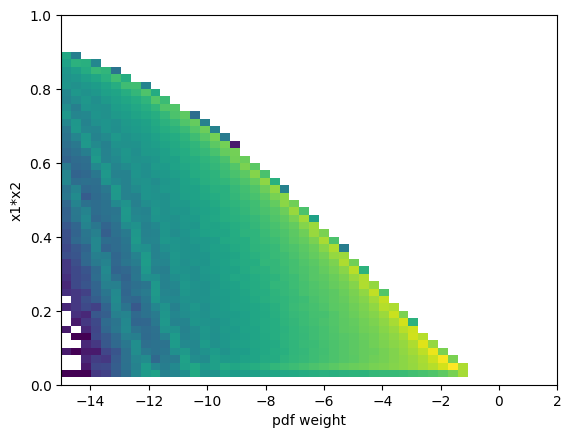

In [119]:
plt.hist2d(np.log10(pdf_weight.numpy()), (x1*x2).numpy(), 
           bins=(50,50), range=((-15,2), (0,1)),
           norm=colors.LogNorm()
          )
plt.xlabel("pdf weight")
plt.ylabel("x1*x2")

## S-matrix evaluation

In [20]:
def eval_smatrix(momenta):
    inputs = np.transpose(momenta.numpy(), (0,2,1))
    output = torch.zeros((momenta.shape[0]))
    for i in range(inputs.shape[0]):
        output[i] = hardscatter.smatrix_ttH([21,21,25,6,-6], inputs[i])
    return output

In [24]:
import numba
@numba.jit
def eval_smatrix_numba(momenta):
    inputs = np.transpose(momenta.numpy(), (0,2,1))
    output = torch.zeros((momenta.shape[0]))
    for i in range(inputs.shape[0]):
        output[i] = hardscatter.smatrix_ttH([21,21,25,6,-6], inputs[i])
    return output

In [22]:
%%timeit
out = eval_smatrix(momenta)

2.85 s ± 81.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
a = eval_smatrix_numba(momenta)

/tmp/ipykernel_69809/89146249.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "eval_smatrix_numba" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_69809/89146249.py (4)

File "../../../../../../tmp/ipykernel_69809/89146249.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
/tmp/ipykernel_69809/89146249.py:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "eval_smatrix_numba" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../tmp/ipykernel_69809/89146249.py", line 6:
<source missing, REPL/exec in use?>

  @numba.jit
/home/valsdav/code/MEM/MEMFlow/myenv/lib64/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "eval_smatrix_numba" was compiled in object mode without forceobj=True, but has lifted loops.


2.9 s ± 59.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
out = eval_smatrix(momenta)

Text(0.5, 0, '$log_{10}(XS)$')

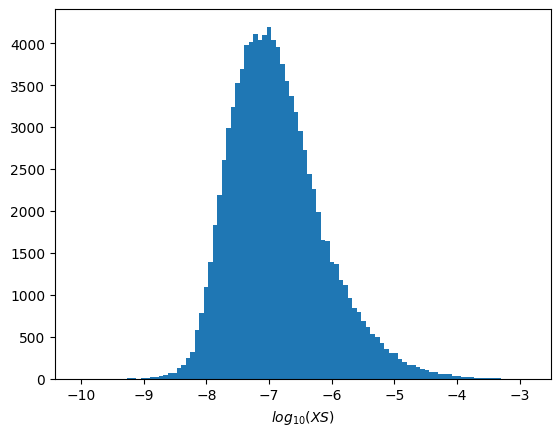

In [27]:
plt.hist(np.log10(out), bins=100)
plt.xlabel("$log_{10}(XS)$")

In [28]:
shat = x1 * x2 * E_CM**2
tot_weight = w*pdf_weight/(2*shat)

In [29]:
tot_weight

tensor([4.7995e-14, 1.1742e-14, 9.0610e-11,  ..., 5.5693e-09, 6.8054e-13,
        5.2935e-09], dtype=torch.float64)

In [30]:
I = torch.sum(out*tot_weight)/ N
I

tensor(1.9387e-13, dtype=torch.float64)

## Integral estimate

In [136]:
y2avg = torch.sum(tot_weight*out**2)/N
yavg2 = (torch.sum(tot_weight*out)/N)**2
std = torch.sqrt(y2avg - yavg2)/np.sqrt(N)

In [137]:
f"Integral estimate: {I} +- {std}"

'Integral estimate: 1.9523389101765974e-13 +- 3.2172028099000466e-12'

## Control plots

/tmp/ipykernel_50191/4036513371.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist2d(np.log10((out).numpy()), np.log10(tot_weight.numpy()), bins=100, range=((-10,-2),(-24,-4)),


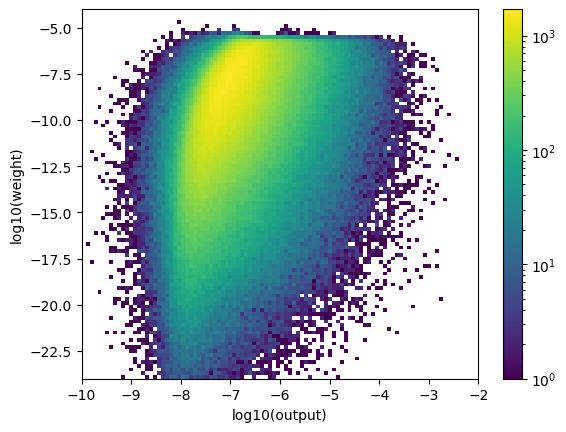

In [128]:
plt.hist2d(np.log10((out).numpy()), np.log10(tot_weight.numpy()), bins=100, range=((-10,-2),(-24,-4)),
          norm=colors.LogNorm())
plt.xlabel("log10(output)")
plt.ylabel("log10(weight)")
plt.colorbar()

/tmp/ipykernel_50191/448706098.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist2d((x1*x2).numpy(), np.log10(tot_weight.numpy()), bins=100, range=((0,1),(-20,-4)),


Text(0, 0.5, 'log(weight)')

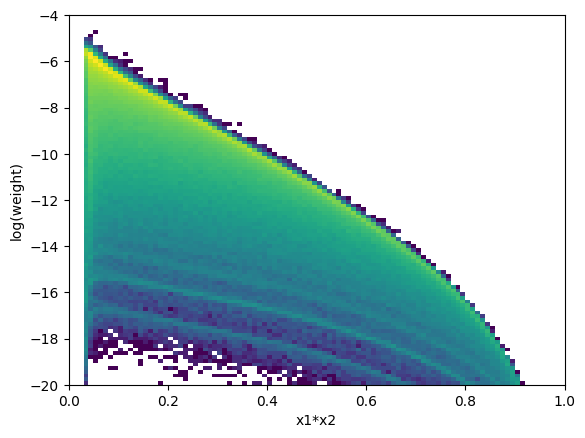

In [130]:
plt.hist2d((x1*x2).numpy(), np.log10(tot_weight.numpy()), bins=100, range=((0,1),(-20,-4)),
          norm=colors.LogNorm())
plt.xlabel("x1*x2")
plt.ylabel("log(weight)")

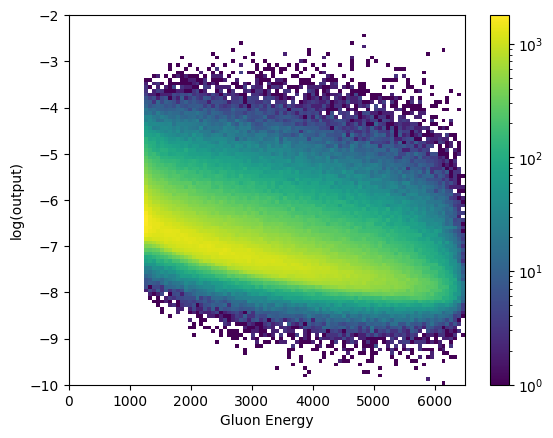

In [144]:
plt.hist2d(momenta[:,0,0].numpy(), np.log10(out.numpy()), bins=100, range=((0,6500),(-10,-2)),
          norm=colors.LogNorm())
plt.xlabel("Gluon Energy")
plt.ylabel("log(output)")
plt.colorbar()

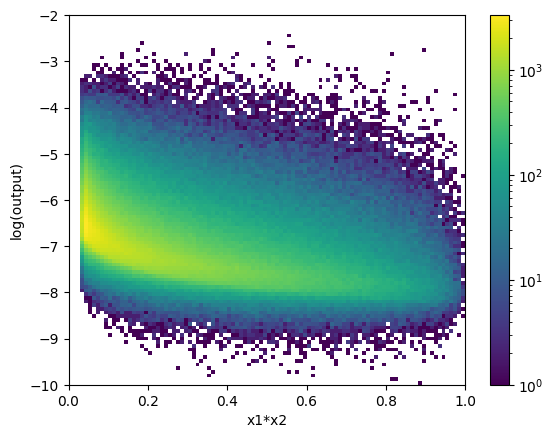

In [132]:
plt.hist2d(((x1*x2).numpy()), np.log10(out.numpy()), bins=100, range=((0,1),(-10,-2)),
          norm=colors.LogNorm())
plt.xlabel("x1*x2")
plt.ylabel("log(output)")
plt.colorbar()

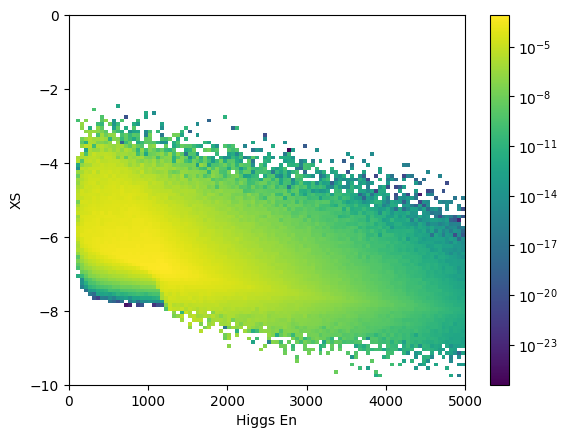

In [133]:
plt.hist2d(momenta[:,2,0].numpy(), np.log10(out.numpy()), 
           weights=tot_weight,
           bins=(100,100),
           range=((0,5000),(-10,0)),
          norm=colors.LogNorm())
plt.xlabel("Higgs En")
plt.ylabel("XS")
plt.colorbar()

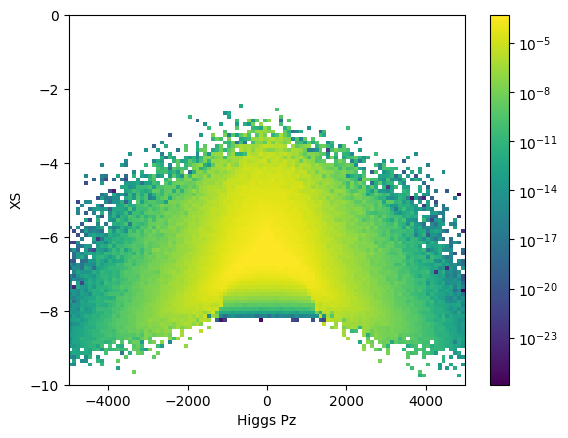

In [134]:
plt.hist2d(momenta[:,2,3].numpy(), np.log10(out.numpy()), 
           weights=tot_weight,
           bins=(100,100), range=((-5000,5000),(-10,0)),
          norm=colors.LogNorm())
plt.xlabel("Higgs Pz")
plt.ylabel("XS")
plt.colorbar()

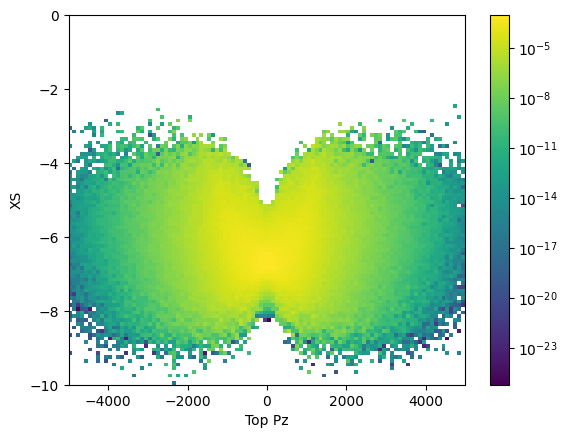

In [135]:
plt.hist2d(momenta[:,3,3].numpy(), np.log10(out.numpy()), 
           weights=tot_weight,
           bins=(100,100), range=((-5000,5000),(-10,0)),
          norm=colors.LogNorm())
plt.xlabel("Top Pz")
plt.ylabel("XS")
plt.colorbar()